In [1]:
# Instalacja biblioteki potrzebnej do usunięci emoji
!pip install demoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Podłączenie się do usługi google drive
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1. Import potrzebnych bibliotek.

In [3]:
import nltk
from nltk.corpus import stopwords
# TweetTokenizer przeznaczony dla tekstów na tweeterze
# RegexpTokenizer dla bardziej złożonych struktur, można dostosować wzorzec wyrażenia regularnego
from nltk.tokenize import TweetTokenizer, RegexpTokenizer 
from nltk.stem import WordNetLemmatizer, SnowballStemmer, LancasterStemmer 
from nltk import FreqDist
import pandas as pd
import demoji
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Pobranie niezbędnych plików
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Języki, w których biblioteka NLTK ma dostępne listę stopwords.**

In [4]:
print(pd.DataFrame(stopwords.fileids(), columns=["Dostępne języki"]))

# Utworzenie zmiennej listy stopwords w języku angielskim
stopwords_en = stopwords.words("english")

   Dostępne języki
0           arabic
1      azerbaijani
2           basque
3          bengali
4          catalan
5          chinese
6           danish
7            dutch
8          english
9          finnish
10          french
11          german
12           greek
13          hebrew
14        hinglish
15       hungarian
16      indonesian
17         italian
18          kazakh
19          nepali
20       norwegian
21      portuguese
22        romanian
23         russian
24         slovene
25         spanish
26         swedish
27           tajik
28         turkish


# 2. Utworzenie ramek danych przeznaczonych do ćwiczeń z biblioteką NLTK.

In [5]:
# Lista tweetów
tweety = ["@ayyytylerb 4+8=12<24>35 that is 3/6 7^5 ~so true drink lots of coffee|tea 😞",
"RT @bryzy_brib: Senior March tmw morning at 7:25 A.M. in the SENIOR lot. Get up early, make yo coffee/breakfast, cus this will only happen ?",
"If you believe in #gunsense tomorrow would be a very good day to have your coffee any place BUT @Starbucks Guns+Coffee=#nosense @MomsDemand",
"My cute coffee mug - 5.8$. http://t.co/2udvMU6XIG",
"RT @slaredo21: I wish we had Starbucks here... Cause coffee dates in the morning sound perff!",
"Does anyone ever get a cup of coffee before a cocktail??",
"I like my coffee like I like my women...black, bitter, and preferably fair trade. I love #Archer",
"@dreamwwediva ya didn't have coffee did ya?",
"RT @iDougherty42: I just want\r\n some coffee.",
"RT @Dorkv76: I can't care before coffee.",
"No lie I wouldn't mind coming home smelling like coffee",
"RT @JonasWorldFeed: Play Ping Pong with Joe. Take a tour of the stage with Nick. Have coffee with Kevin. Charity auction: https://t.co/VTkK?",
"Have I ever told any of you that Tate Donovan bought my stepmom coffee?",
"RT @JonasWorldFeed: Play Ping Pong with Joe. Take a tour of the stage with Nick. Have coffee with Kevin. Charity auction: https://t.co/VTkK?",
"@HeatherWhaley I was about 2 joke it takes 2 hands to hold hot coffee...then I read headline! #Don'tDrinkNShoot",
"RT @MoveTheSticks: Charlie Whitehurst looks like he should be working \nat a coffee shop in Portland or hosting a renovation show on HGTV.",
"Coffee always makes everything better.",
"RT @AdelaideReview: Food For Thought: @Annabelleats shares a delicious Venison and Porcini Mushroom Pie Recipe. http://t.co/N8O7vqFKWN http?",
"RT @LittleMelss: lmfao!!!@bryanlaca: nahhh Melanie u is fa sho like an ummm a Coffee table ;) ) yeeeee lmaoo",
"I wonder if Christian Colon will get a cup of coffee once the rosters\r expand to 40 man in September. Really nothing to lose by doing so."]
# Przekształcenie listy na ramkę danych
tweety = pd.DataFrame(tweety, columns = ["Tweety"])


# Lista przysłów
przyslowia = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/lematyzacja/przyslowia.txt", sep=",", header=None)
# Przekształcenie ramki danych do postaci długiej
przyslowia = przyslowia.stack().reset_index(drop=True).to_frame(name='przyslowia')

Wyświetlenie zawartości ramki danych tweety.

In [6]:
print(tweety)

                                               Tweety
0   @ayyytylerb 4+8=12<24>35 that is 3/6 7^5 ~so t...
1   RT @bryzy_brib: Senior March tmw morning at 7:...
2   If you believe in #gunsense tomorrow would be ...
3   My cute coffee mug - 5.8$. http://t.co/2udvMU6XIG
4   RT @slaredo21: I wish we had Starbucks here......
5   Does anyone ever get a cup of coffee before a ...
6   I like my coffee like I like my women...black,...
7         @dreamwwediva ya didn't have coffee did ya?
8      RT @iDougherty42: I just want\r\n some coffee.
9            RT @Dorkv76: I can't care before coffee.
10  No lie I wouldn't mind coming home smelling li...
11  RT @JonasWorldFeed: Play Ping Pong with Joe. T...
12  Have I ever told any of you that Tate Donovan ...
13  RT @JonasWorldFeed: Play Ping Pong with Joe. T...
14  @HeatherWhaley I was about 2 joke it takes 2 h...
15  RT @MoveTheSticks: Charlie Whitehurst looks li...
16             Coffee always makes everything better.
17  RT @AdelaideReview: Food

Wyświetlenie zawartości ramki danych przyslowia

In [7]:
print(przyslowia)

                                          przyslowia
0   Jesień tego nie zrodzi, czego wiosna nie zasiała
1       Czego wiosna nie zasiała – jesień nie urodzi
2             Św. Bartłomiej pogodny, jesień pogodna
3  Bartłomiej zwiastuje, jaka jesień następuje, i...
4        Bartłomiej zwiastuje, jaka jesień następuje
5  Bartłomieja cały wrzesień naśladuje, i z nim j...
6  Bartłomieja świętego dzień w jakiej zostaje po...
7     Jaki Bartek niesie dzień, taka będzie i jesień
8     Jaki Bartek niesie dzień, taka będzie i jesień
9  Jaki Bartek, taki wrzesień, jaki Marcin, taka ...


# 3. Przygotowanie tekstów

Normalizacja

In [8]:
# Funkcja do normalizacji tweetów
def czysc_tekst(tekst):
    
    temp = re.sub("\s{2,}", " ", tekst) #usunięcie podwójnych spacji
    temp = re.sub("(\r\n|\r|\n)", " ", temp) #usunięcie przerw między słowami
    temp = temp.lower() #zamiana wszystkich znaków na małe litery
    temp = re.sub("rt", "", temp) #usunięcie retweetów
    temp = re.sub("&amp", "", temp) #usunięcie kodu htmlowego
    temp = re.sub("#[a-z,A-Z]*", "", temp) #usunięcie hasztagów
    temp = re.sub("@\w+", "", temp) #usunięcie wzmianek, oznaczeń, tagowań
    temp = re.sub("(f|ht)(tp)([^ ]*)", "", temp) #usunięcie urlów
    temp = re.sub("http(s?)([^ ]*)", "", temp) #usunięcie urlów
    temp = re.sub("[!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]", " ", temp) #usunięcie znaków specjalnych
    temp = re.sub("\d", "", temp) #usunięcie cyfr
    temp = re.sub("\s{2,}", " ", temp) #ponowne usunięcie podwójnych spacji
    temp = demoji.replace(temp, '') # usunięcie emoji z tweetów
    temp = temp.strip() #usunięcie spacji lub odstępów na końcach tekstu
    return temp
tweety['Tweety'] = tweety['Tweety'].apply(lambda x: czysc_tekst(x))

Usunięcie duplikatów

In [9]:
tweety.drop_duplicates(subset=['Tweety'], inplace=True)

Stemming, tokenizacja i usunięcie stopwords

In [10]:
snowball = SnowballStemmer("english")
lancaster = LancasterStemmer()
lem = WordNetLemmatizer()
tweety['tokeny bez stemming'] = tweety['Tweety'].apply(lambda x: [word for word in x.split() if word not in stopwords_en])
tweety['tokeny snowball'] = tweety['Tweety'].apply(lambda x: [snowball.stem(word) for word in x.split() if word not in stopwords_en])
tweety['tokeny lancaster'] = tweety['Tweety'].apply(lambda x: [lancaster.stem(word) for word in x.split() if word not in stopwords_en])

WordNetLematizer:<br>
'n' - rzeczownik (ang. noun)<br>
'v' - czasownik (ang. verb)<br>
'a' - przymiotnik (ang. adjective)<br>
's' - przymiotnik (ang. satellite adjective)<br>
'r' - przysłówek (ang. adverb)

In [11]:
tweety['tokeny wordnet'] = tweety['Tweety'].apply(lambda x: [lem.lemmatize(word, 'n') for word in x.split() if not word in stopwords_en]) 

WordCloud z tweetami bez i z stemmingiem.

In [12]:
bez_stemmingu = ' '.join(tweety['tokeny bez stemming'].apply(lambda x: ' '.join(x)))
snowball_stemming = ' '.join(tweety['tokeny snowball'].apply(lambda x: ' '.join(x)))
lancaster_stemming = ' '.join(tweety['tokeny lancaster'].apply(lambda x: ' '.join(x)))
wordnet_lematizer = ' '.join(tweety['tokeny wordnet'].apply(lambda x: ' '.join(x)))

In [13]:
wordcloud_bez = WordCloud(background_color="white", width=800, height=400, max_words=50).generate(bez_stemmingu)
wordcloud_snowball = WordCloud(background_color="white", width=800, height=400, max_words=50).generate(snowball_stemming)
wordcloud_lancaster = WordCloud(background_color="white", width=800, height=400, max_words=50).generate(lancaster_stemming)
wordcloud_wordnet = WordCloud(background_color="white", width=800, height=400, max_words=50).generate(wordnet_lematizer)

Porównanie Snowball, Lancaster oraz WordNet lematizer

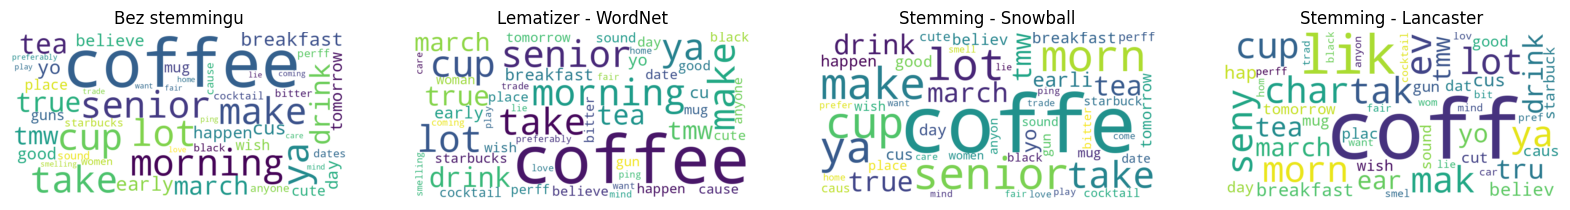

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(wordcloud_bez, interpolation='bilinear')
axes[0].set_title('Bez stemmingu')
axes[1].imshow(wordcloud_wordnet, interpolation='bilinear')
axes[1].set_title('Lematizer - WordNet')
axes[2].imshow(wordcloud_snowball, interpolation='bilinear')
axes[2].set_title('Stemming - Snowball')
axes[3].imshow(wordcloud_lancaster, interpolation='bilinear')
axes[3].set_title('Stemming - Lancaster')

for ax in axes:
    ax.axis("off")

plt.show()

# Zadanie z przyslowiami
*Biblioteka NLTK nie obsługuje języka Polskiego i nie ma możliwość obliczania TF-IDF w sposób automatyczny. <br>Jedyna możliwość to obliczenie TF.

In [15]:
tokenizer = RegexpTokenizer(r'\w+')
przyslowia['przyslowia tokenizacja'] = przyslowia['przyslowia'].apply(lambda x: tokenizer.tokenize(x.lower()))

Dodanie słownika z pliku, który był wykorzystywany na ćwiczeniach w celu przeprowadzenia lematyzacji, <br>ponieważ NLTK nie obsługuje języka polskiego.

In [16]:
slownik_przyslowia = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/data/lematyzacja/slownik.txt", sep=";", header=None, names=["lemma", "term"]) 
slownik_przyslowia = dict(zip(slownik_przyslowia['term'], slownik_przyslowia['lemma']))

In [17]:
przyslowia['przyslowia lematyzacja'] = przyslowia['przyslowia tokenizacja'].apply(lambda x: [slownik_przyslowia[word] if word in slownik_przyslowia else word for word in x])

In [18]:
termy = [y for y in list(set(' '.join(przyslowia['przyslowia lematyzacja'].apply(lambda x: ' '.join(x))).split())) if len(y)>1 and y not in ["czy","czego", "tego"]]
termy.sort()

Tworzenie macierzy wystąpień:<br>
.freq() - zwraca częstotliwość wystąpień<br>
.get() - zwraca liczbę wystąpień, brak oznacza NaN <br>
.most_common(n) - zwraca n najczęściej występujących termów



In [19]:
macierz_wystąpień = pd.DataFrame()
macierz_wystąpień['termy'] = termy

macierz_częstotliwości = pd.DataFrame()
macierz_częstotliwości['termy'] = termy

for i, tekst in enumerate(przyslowia['przyslowia lematyzacja']):
  freq_dist = FreqDist(tekst)
  macierz_wystąpień[i] = [freq_dist.get(x) for x in macierz_wystąpień['termy']]
  macierz_częstotliwości[i] = [freq_dist.freq(x) for x in macierz_częstotliwości['termy']]

In [20]:
macierz_wystąpień

,termy,0,1,2,3,4,5,6,7,8,9
0,bartłomiej,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,bez,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,być,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN
3,cały,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,dać,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
5,dostatek,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
6,dożyć,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
7,dzień,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN
8,jaki,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,2.0
9,jesień,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [21]:
macierz_częstotliwości

,termy,0,1,2,3,4,5,6,7,8,9
0,bartłomiej,0.000,0.000000,0.2,0.083333,0.2,0.125,0.083333,0.125,0.125,0.125
1,bez,0.000,0.000000,0.0,0.000000,0.0,0.000,0.083333,0.000,0.000,0.000
2,być,0.000,0.000000,0.0,0.000000,0.0,0.000,0.000000,0.125,0.125,0.000
3,cały,0.000,0.000000,0.0,0.000000,0.0,0.125,0.000000,0.000,0.000,0.000
4,dać,0.000,0.000000,0.0,0.000000,0.0,0.000,0.083333,0.000,0.000,0.000
5,dostatek,0.000,0.000000,0.0,0.083333,0.0,0.000,0.000000,0.000,0.000,0.000
6,dożyć,0.000,0.000000,0.0,0.083333,0.0,0.000,0.000000,0.000,0.000,0.000
7,dzień,0.000,0.000000,0.0,0.000000,0.0,0.000,0.083333,0.125,0.125,0.000
8,jaki,0.000,0.000000,0.0,0.083333,0.2,0.000,0.083333,0.125,0.125,0.250
9,jesień,0.125,0.142857,0.2,0.083333,0.2,0.125,0.083333,0.125,0.125,0.000


# Możliwości biblioteki NLTK:

1. Tokenizacja: NLTK oferuje różne metody tokenizacji, które pozwalają na podział tekstu na słowa i znaki specjalne, co jest niezbędne do dalszej analizy tekstu.<br>

2. Tagowanie części mowy: Biblioteka ta umożliwia oznaczanie słów w tekście z ich częścią mowy, dzięki czemu można określić, na przykład, czy dany wyraz jest rzeczownikiem, czasownikiem, czy przymiotnikiem.<br>

3. Analiza sentymentu: Biblioteka ta umożliwia ocenę sentymentu tekstu, czyli określenie, czy dany tekst wyraża pozytywne, negatywne, czy neutralne emocje.<br>

4. Generowanie tekstu: Biblioteka ta oferuje również narzędzia do generowania tekstu na podstawie wzorców językowych.<br>

5. Dostępność korpusów: NLTK zawiera wiele gotowych korpusów tekstów w różnych językach, które mogą być używane do szkolenia modeli językowych i analizy tekstu.<br>

6. Klasyfikacja tekstu: NLTK pozwala na klasyfikowanie tekstu, czyli przypisywanie tekstu do jednej z kilku kategorii na podstawie jego zawartości.<br>

**1. Tokenizacja**

In [22]:
tokenized_tweets = [nltk.word_tokenize(tweet) for tweet in tweety['Tweety']]
tweety_nltk = pd.DataFrame()
tweety_nltk['Tweety'] = tweety['Tweety']
tweety_nltk['Tokeny'] = tokenized_tweets
tweety_nltk

,Tweety,Tokeny
0,that is so true drink lots of coffee tea,"[that, is, so, true, drink, lots, of, coffee, ..."
1,senior march tmw morning at a m in the senior ...,"[senior, march, tmw, morning, at, a, m, in, th..."
2,if you believe in tomorrow would be a very goo...,"[if, you, believe, in, tomorrow, would, be, a,..."
3,my cute coffee mug,"[my, cute, coffee, mug]"
4,i wish we had starbucks here cause coffee date...,"[i, wish, we, had, starbucks, here, cause, cof..."
5,does anyone ever get a cup of coffee before a ...,"[does, anyone, ever, get, a, cup, of, coffee, ..."
6,i like my coffee like i like my women black bi...,"[i, like, my, coffee, like, i, like, my, women..."
7,ya didn t have coffee did ya,"[ya, didn, t, have, coffee, did, ya]"
8,i just want some coffee,"[i, just, want, some, coffee]"
9,i can t care before coffee,"[i, can, t, care, before, coffee]"


**2. Tagowanie części mowy**
*   CC: spójnik łączący wyrazy, np. "and" (i), "or" (lub)
*   CD: liczebnik, np. "one" (jeden), "two" (dwa)
*   DT: określnik (determiner), np. "the" (ten, ta, to), "this" (ten, ta, to)
*   IN: przyimek (preposition), np. "in" (w), "on" (na)
*   JJ: przymiotnik (adjective), np. "happy" (szczęśliwy), "red" (czerwony)
*   NN: rzeczownik (noun), np. "dog" (pies), "cat" (kot)
*   PRP: zaimek osobowy (personal pronoun), np. "I" (ja), "you" (ty)
*   VB: czasownik (verb), np. "run" (biegać), "eat" (jeść)
*   RB: przysłówek (adverb), np. "quickly" (szybko), "well" (dobrze)



In [23]:
nltk.download('averaged_perceptron_tagger')
tweety_nltk['Tagowanie'] = [nltk.pos_tag(tweet) for tweet in tweety_nltk['Tokeny']]
tweety_nltk[['Tweety', 'Tagowanie']]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,Tweety,Tagowanie
0,that is so true drink lots of coffee tea,"[(that, DT), (is, VBZ), (so, RB), (true, JJ), ..."
1,senior march tmw morning at a m in the senior ...,"[(senior, JJ), (march, NN), (tmw, NN), (mornin..."
2,if you believe in tomorrow would be a very goo...,"[(if, IN), (you, PRP), (believe, VBP), (in, IN..."
3,my cute coffee mug,"[(my, PRP$), (cute, JJ), (coffee, NN), (mug, NN)]"
4,i wish we had starbucks here cause coffee date...,"[(i, JJ), (wish, NN), (we, PRP), (had, VBD), (..."
5,does anyone ever get a cup of coffee before a ...,"[(does, VBZ), (anyone, NN), (ever, RB), (get, ..."
6,i like my coffee like i like my women black bi...,"[(i, NN), (like, IN), (my, PRP$), (coffee, NN)..."
7,ya didn t have coffee did ya,"[(ya, NN), (didn, NN), (t, NN), (have, VBP), (..."
8,i just want some coffee,"[(i, NN), (just, RB), (want, VB), (some, DT), ..."
9,i can t care before coffee,"[(i, NN), (can, MD), (t, VB), (care, NN), (bef..."


**3. Analiza sentymentu**

In [24]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()
tweety_nltk['Sentyment'] = [sia.polarity_scores(tweet) for tweet in tweety_nltk['Tweety']]
tweety_nltk[['Tweety', 'Sentyment']]

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Tweety,Sentyment
0,that is so true drink lots of coffee tea,"{'neg': 0.0, 'neu': 0.689, 'pos': 0.311, 'comp..."
1,senior march tmw morning at a m in the senior ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,if you believe in tomorrow would be a very goo...,"{'neg': 0.0, 'neu': 0.896, 'pos': 0.104, 'comp..."
3,my cute coffee mug,"{'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound..."
4,i wish we had starbucks here cause coffee date...,"{'neg': 0.0, 'neu': 0.816, 'pos': 0.184, 'comp..."
5,does anyone ever get a cup of coffee before a ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
6,i like my coffee like i like my women black bi...,"{'neg': 0.113, 'neu': 0.323, 'pos': 0.565, 'co..."
7,ya didn t have coffee did ya,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
8,i just want some coffee,"{'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'comp..."
9,i can t care before coffee,"{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'comp..."


**4. Generowanie tekstu**

In [25]:
from nltk.util import ngrams
import random
tweety_nltk['Generowany'] = [' '.join([' '.join(bigram) for bigram in random.sample(list(ngrams(tweet, 2)), k=2)]) for tweet in tweety_nltk['Tokeny']]
tweety_nltk[['Tweety', 'Generowany']]

,Tweety,Generowany
0,that is so true drink lots of coffee tea,that is lots of
1,senior march tmw morning at a m in the senior ...,march tmw lot get
2,if you believe in tomorrow would be a very goo...,coffee any day to
3,my cute coffee mug,cute coffee my cute
4,i wish we had starbucks here cause coffee date...,cause coffee morning sound
5,does anyone ever get a cup of coffee before a ...,ever get a cup
6,i like my coffee like i like my women black bi...,i like bitter and
7,ya didn t have coffee did ya,coffee did didn t
8,i just want some coffee,want some i just
9,i can t care before coffee,before coffee i can


**5. Dostępność korpusów**

In [26]:
from nltk.corpus import twitter_samples
nltk.download('twitter_samples')
twitter_samples.strings('positive_tweets.json')[:5]

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days']

**6. Klasyfikacja tekstu na podstawie pozytywnych i negatywnych tweetów**

In [27]:
from nltk.classify import NaiveBayesClassifier

positive_tweets = [(czysc_tekst(tweet), 'positive') for tweet in twitter_samples.strings('positive_tweets.json')]
negative_tweets = [(czysc_tekst(tweet), 'negative') for tweet in twitter_samples.strings('negative_tweets.json')]
all_tweets = positive_tweets + negative_tweets
random.shuffle(all_tweets)

train_set = all_tweets[:8000]
test_set = all_tweets[8000:]

def extract_features(tweet):
    features = {}
    for word in tweet:
        if isinstance(word, str):
            features[word.lower()] = True
    return features

classifier = NaiveBayesClassifier.train([(extract_features(tweet), label) for (tweet, label) in train_set])

print("Accuracy:", nltk.classify.accuracy(classifier, [(extract_features(tweet), label) for (tweet, label) in test_set]))
classifier.show_most_informative_features(5)

Accuracy: 0.516
Most Informative Features
                       � = True           negati : positi =      4.4 : 1.0
                       – = True           positi : negati =      3.6 : 1.0
                       쇼 = True           negati : positi =      3.0 : 1.0
                       ✧ = True           positi : negati =      2.6 : 1.0
                       ” = True           negati : positi =      1.9 : 1.0


In [28]:
tweety_nltk['Klasyfikacja'] = [classifier.classify(extract_features(tweet)) for tweet in tweety_nltk['Tokeny']]
tweety_nltk[['Tweety', 'Klasyfikacja']]

,Tweety,Klasyfikacja
0,that is so true drink lots of coffee tea,positive
1,senior march tmw morning at a m in the senior ...,negative
2,if you believe in tomorrow would be a very goo...,positive
3,my cute coffee mug,positive
4,i wish we had starbucks here cause coffee date...,negative
5,does anyone ever get a cup of coffee before a ...,positive
6,i like my coffee like i like my women black bi...,negative
7,ya didn t have coffee did ya,positive
8,i just want some coffee,negative
9,i can t care before coffee,negative
